In [1]:
!nvidia-smi

Sun Jan 28 13:59:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

##**Data Gathering and Preprocessing**

In [6]:
!git clone https://github.com/cardstdani/WasteClassificationNeuralNetwork.git

Cloning into 'WasteClassificationNeuralNetwork'...
remote: Enumerating objects: 5092, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 5092 (delta 10), reused 23 (delta 9), pack-reused 5068
Receiving objects: 100% (5092/5092), 223.89 MiB | 31.94 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (5082/5082), done.


In [7]:
#LOAD DATA
DIR = "/content/WasteClassificationNeuralNetwork/WasteImagesDataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5078 files belonging to 9 classes.
Using 4571 files for training.
Found 5078 files belonging to 9 classes.
Using 507 files for validation.
['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


##**Model Training**

In [ ]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 50
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


36/36 [==============================] - 14s 250ms/step - loss: 229.8705 - accuracy: 0.7042 - val_loss: 79.7820 - val_accuracy: 0.8876
Epoch 2/50
36/36 [==============================] - 10s 226ms/step - loss: 32.0021 - accuracy: 0.7933 - val_loss: 8.5222 - val_accuracy: 0.5957
Epoch 3/50
36/36 [==============================] - 10s 225ms/step - loss: 5.8862 - accuracy: 0.5681 - val_loss: 4.5838 - val_accuracy: 0.5779
Epoch 4/50
36/36 [==============================] - 10s 226ms/step - loss: 4.4891 - accuracy: 0.5710 - val_loss: 4.3758 - val_accuracy: 0.5700
Epoch 5/50
36/36 [==============================] - 10s 224ms/step - loss: 4.3943 - accuracy: 0.5690 - val_loss: 4.3053 - val_accuracy: 0.5957
Epoch 6/50
36/36 [==============================] - 10s 225ms/step - loss: 4.3347 - accuracy: 0.5811 - val_loss: 4.2623 - val_accuracy: 0.6036
Epoch 7/50
36/36 [==============================] - 10s 224ms/step - loss: 4.2904 - accuracy: 0.6047 - val_loss: 4.2111 - val_accuracy: 0.6252
Epoch 

In [ ]:
model.save("/content/model.h5")
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_8 (Rescaling)        (None, 256, 256, 3)  0           ['input_9[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling_8[0][0]']            
                                )                                                                 
                                                                                            

##**Model Evaluation**

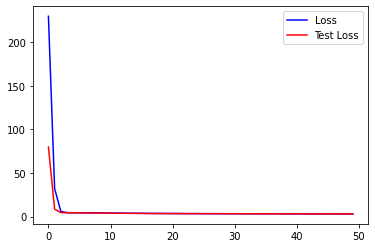

In [ ]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

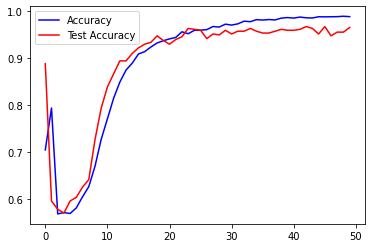

In [ ]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

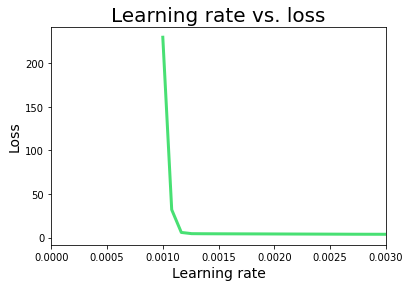

In [ ]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

In [4]:
# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model

# load model
model = load_model('/content/WasteClassificationModel.h5')

Input image urlhttps://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fsoundproofpanda.com%2Fwp-content%2Fuploads%2F2020%2F03%2Findustrial-use-styrofoam.jpg&f=1&nofb=1&ipt=749ded72536295b9ca54904ee84000056a1369573fbd3566ad69304f32dd79e8&ipo=images
1/1 [==============================] - 0s 22ms/step
Trash


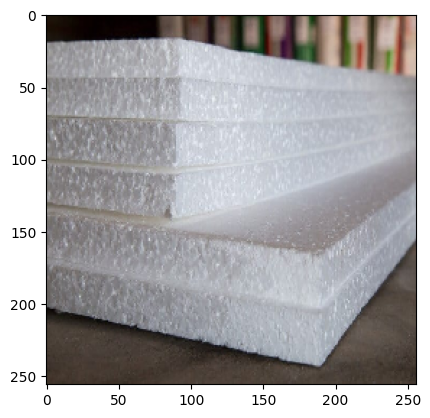

In [27]:
#plastic spoon trash - https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.webstaurantstore.com%2Fimages%2Fproducts%2Fmain%2F64681%2F268471%2Fvisions-heavy-weight-white-plastic-soup-spoon-100-pack.jpg&f=1&nofb=1&ipt=b61a42b7902f0e4a1fb5240f31652e737a711b2d0771433172a2fb0901b80f7a&ipo=images
# cardboard recycle - https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi.pinimg.com%2Foriginals%2F59%2F7f%2Ff4%2F597ff4093d63be409a41e46793035fb8.jpg&f=1&nofb=1&ipt=1ea8e80c89fea54d84f8b520cefb7f69c54900df06738abf9c07fd605c0f421e&ipo=images
# soda cans recycle - https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fsouthpark.garlicknotpizza.com%2Fwp-content%2Fuploads%2Fsites%2F15%2F2020%2F08%2Fassorted-soda.png&f=1&nofb=1&ipt=9fcff14d2b53fe4e80f90e03b1e90209dfb8cc86e115fe25e0eb40de98d62950&ipo=images
# styrofoam trash - https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fsoundproofpanda.com%2Fwp-content%2Fuploads%2F2020%2F03%2Findustrial-use-styrofoam.jpg&f=1&nofb=1&ipt=749ded72536295b9ca54904ee84000056a1369573fbd3566ad69304f32dd79e8&ipo=images


import requests

link = input("Input image url")

img_data = requests.get(link).content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "/content/img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

plt.imshow(img)



pred = classes[np.argmax(predictions)]

if predictions[0][np.argmax(predictions)]*100 < 50.0:
  pred = None
  print("Trash")

elif "Other" in pred:
  print("Trash")

elif "Plastic" in pred or "Paper" in pred:
  print("Recycle")

elif "Organic" in pred or "Wood" in pred:
  print("Compost")

elif "Alum" in pred:
  print("Recycle")

else:
  print("Trash")


1/1 [==============================] - 0s 27ms/step


<Figure size 1000x1000 with 0 Axes>

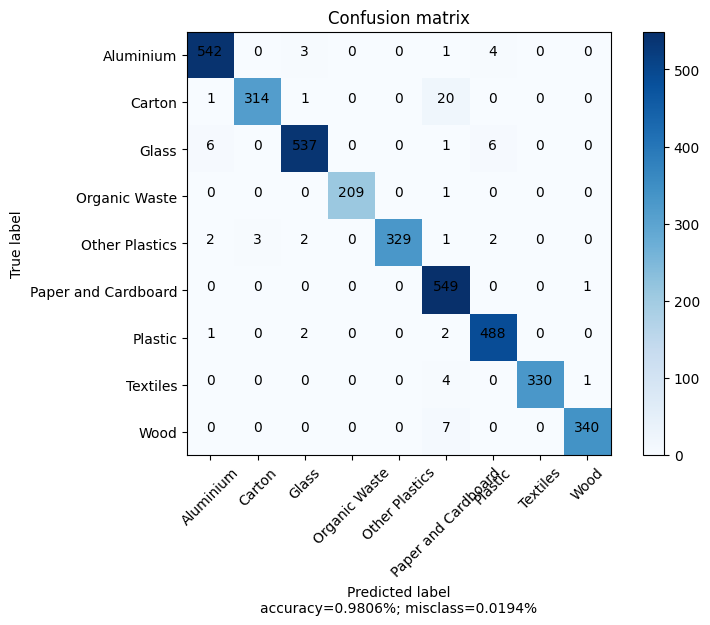

In [28]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

"""
for images, labels in test_dataset.take(50):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""
path = "/content/WasteClassificationNeuralNetwork/WasteImagesDataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

**Advanced Filter Visualization**

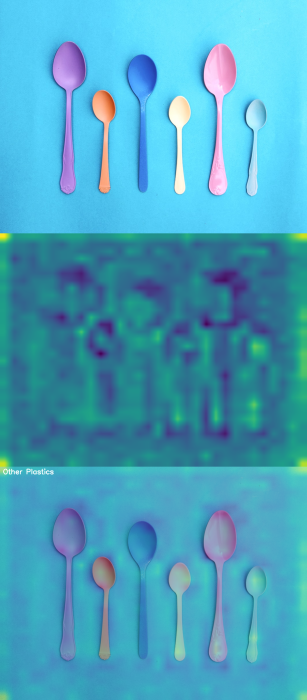

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import imutils

class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    if self.layerName is None:
      self.layerName = self.find_target_layer()

  def find_target_layer(self):
    for layer in reversed(self.model.layers):
      if len(layer.output_shape) == 4:
        return layer.name
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return (heatmap, output)

path = "/content/img.jpg"
orig = cv2.imread(path)
resized = cv2.resize(orig, (256, 256))

image = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
cam = GradCAM(model, np.argmax(predictions[0]), "expanded_conv_6/expand")
heatmap = cv2.resize(cam.compute_heatmap(image), (orig.shape[1], orig.shape[0]))

#heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

#cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, classes[np.argmax(predictions)], (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)